# Cursive English Handwritten Character Classification: Exploratory Data Analysis
# ------------------------------------------------------------------------------

### Notebook Overview:
This notebook will be used to explore and understand the cursive handwriting dataset derived from the CVL database. We will be:
1. Previewing Dataset
2. Check Data Quality and Clean
3. Loading the Data and Perform Split
4. Class Distribution Analysis
5. Visual Explorations
6. Statistical Summaries
7. Preliminary Feature or Embedding Analysis
8. EDA Conclusion

In [1]:
%pip install torchsummary pytest
%pip install pandas matplotlib seaborn pillow torchvision scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import torchvision.transforms as transforms
from PIL import Image

import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from sklearn.metrics import confusion_matrix, classification_report
from importlib import reload

# Checking if CUDA is available
flag_cuda = torch.cuda.is_available()

if flag_cuda:
    print("Using GPU")
else:
    print("Using CPU")

Using GPU


## 1. Preview the Data
### In this section, we will:
### 1. Examine the folder structure for our dataset.
### 2. Count how many files are in each subdirectory.
### 3. Visualize a few random images from the `lines`, `pages`, and `words` directories.

In [ ]:
import os
import glob
import random
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter

# Base path for the raw dataset
BASE_PATH = os.path.normpath('cvl-database-1-1/raw_dataset')

# Since only the words folder exists now, we use that:
subfolders = ['words']

print("Folder Structure and File Counts:")
for folder in subfolders:
    folder_path = os.path.join(BASE_PATH, folder)
    all_files = glob.glob(os.path.join(folder_path, '**', '*.*'), recursive=True)
    print(f"- {folder}: {len(all_files)} files found")

def show_random_image(folder_name, num_samples=1):
    """
    Display 'num_samples' random images from the specified folder (including its subfolders).
    """
    folder_path = os.path.join(BASE_PATH, folder_name)
    # Adjust file extension as needed (here using .tif)
    image_files = glob.glob(os.path.join(folder_path, '**', '*.tif'), recursive=True)
    if not image_files:
        print(f"No image files found in '{folder_path}'.")
        return
    random_files = random.sample(image_files, k=min(num_samples, len(image_files)))
    for i, file_path in enumerate(random_files, 1):
        img = Image.open(file_path)
        plt.figure(figsize=(6, 4))
        plt.imshow(img, cmap='gray')  # Adjust cmap if images are RGB.
        plt.title(f"{folder_name.capitalize()} Sample {i}\n{os.path.basename(file_path)}")
        plt.axis('off')
        plt.show()

for folder_name in subfolders:
    print(f"Displaying random images from '{folder_name}' folder:")
    show_random_image(folder_name, num_samples=2)


Folder Structure and File Counts:
- words: 99904 files found


KeyboardInterrupt: 

# 2. Data Quality and Cleaning

In [ ]:
import os
import glob
import re
from PIL import Image
# Base path for the raw dataset
BASE_PATH = os.path.normpath('cvl-database-1-1/raw_dataset')

def filter_german_files(folder_name, extension='tif'):
    folder_path = os.path.join(BASE_PATH, folder_name)
    all_files = glob.glob(os.path.join(folder_path, '**', f'*.{extension}'), recursive=True)
    all_files = [os.path.normpath(f) for f in all_files]

    # Filter out files where the base name contains '-6-'
    filtered_files = [f for f in all_files if not re.search(r'-6-', os.path.basename(f))]
    print(f"Folder: {folder_name} - Original count: {len(all_files)}, Filtered count: {len(filtered_files)}")
    return filtered_files

# Process the 'words' folder only
words_filtered = filter_german_files('words')

def print_max_dimensions(folder_name):
    """
    Iterate through all .tif images in the specified folder and print the maximum width and height.
    """
    max_width = 0
    max_height = 0
    for file_path in folder_name:
        with Image.open(file_path) as img:
            w, h = img.size
            max_width = max(max_width, w)
            max_height = max(max_height, h)
    
    print(f"Maximum width in folder: {max_width}")
    print(f"Maximum height in folder: {max_height}")

# Print maximum dimensions for the 'words' folder
print_max_dimensions(words_filtered)

Folder: words - Original count: 99904, Filtered count: 69184
cvl-database-1-1\raw_dataset\words\0184\0184-3-13-0-Volltransistor-Rechenautomat.tif
Maximum width in folder: 1593
Maximum height in folder: 238


In [3]:
from PIL import Image, ImageOps
import os

def resize_image_to_uniform_size(image_path, target_width, target_height):
    # Open the image
    img = Image.open(image_path)
    current_width, current_height = img.size
    # Calculate padding to center the image within the target dimensions
    padding_left = (target_width - current_width) // 2
    padding_top = (target_height - current_height) // 2
    padding_right = target_width - current_width - padding_left
    padding_bottom = target_height - current_height - padding_top
    # Add padding with a white background (RGB white: 255, 255, 255)
    padded_img = ImageOps.expand(img, (padding_left, padding_top, padding_right, padding_bottom), (255, 255, 255))
    return padded_img

def convert_to_grayscale(img):
    grayscale_img = img.convert('L')
    return grayscale_img

def normalize_image(image):
    """
    Normalize the input grayscale image by applying autocontrast.
    This stretches the pixel values to span the full 0-255 range.
    """
    normalized_img = ImageOps.autocontrast(image)
    return normalized_img

def process_images_in_folder(file_list, target_width, target_height, output_path, final_size):
    # Ensure the output directory exists
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    # Process each file in the list
    for filename in file_list:
        if filename.lower().endswith('.tif'):
            # Resize (pad) the image to uniform dimensions
            padded_image = resize_image_to_uniform_size(filename, target_width, target_height)
            # Convert the padded image to grayscale
            gray_image = convert_to_grayscale(padded_image)
            # Normalize the grayscale image (autocontrast)
            norm_image = normalize_image(gray_image)
            # Scale down the normalized image to the final target size (e.g., for easier CNN processing)
            scaled_image = norm_image.resize(final_size, resample=Image.LANCZOS)
            # Save the final processed image
            output_path_save = os.path.join(output_path, os.path.basename(filename))
            scaled_image.save(output_path_save)

# Define the output path under preprocessed_dataset (you can update the folder name as needed)
words_output_folder = os.path.normpath(os.path.join('cvl-database-1-1', 'preprocessed_dataset', 'words_scaled'))

# Set the target size for padding (based on your stats)
target_width = 1593  # Largest width from your dataset stats
target_height = 238  # Largest height from your dataset stats

# Define the final size after scaling (adjust these dimensions as needed for your CNN)
final_size = (775, 120)

# Process all .tif images in the 'words' folder with the updated pipeline
process_images_in_folder(words_filtered, target_width, target_height, words_output_folder, final_size)

# 3. Loading the Data and Perform Split

In [5]:
import words_helper as wp

classes, train_loader, valid_loader, test_loader, label_dict = wp.createLoaders()
print("Unique classes in dataset:")
for c in classes:
    print(c)

Done creating loaders
Done creating loaders
Unique classes in dataset:
1955
Alas
American
And
Austrian
Binär
Disdaining
European
For
Heinz
Hexagons
House
I
If
Imagine
It
Like
Lines
Mailüfterl
Nomacs
Now
Pentagons
Rechenautomat
Show'd
Squares
Technology
The
Till
Triangles
Typhoon
University
Unknown
Usher
Vienna
When
Which
While
Whirlwind
Wiener
You
Zemanek
a
about
above
ace
achieve
ago
all
all's
an
and
angles
animals
any
are
art
as
asunder
at
ating
ation
automat
away
be
because
been
below
bloody
brain
brandish'd
brave
breath
builder
built
burst
but
by
calculation
came
can
carved
closed
computer
correct
country
countrymen
cultivated
curiosity
cution
daining
damned
dank
deep
deserves
dezimaler
differ
dish'd
do
don't
dows
dreams
each
edges
effect
enough
entire
erally
erating
even
execution
face
faced
feet
few
fierce
figures
first
fissure
fixed
for
fortune
fragments
freely
from
full
gave
gazed
generally
genius
gons
great
had
hard
has
have
he
higher
his
imagination
imaler
in
individuals
ing


# 4. Class Distribution Analysis

Class Distribution for Train set:
of                  :   2171 or 4.5%
the                 :   1854 or 3.8%
a                   :   1225 or 2.5%
on                  :   1153 or 2.4%
or                  :   870 or 1.8%
and                 :   867 or 1.8%
is                  :   769 or 1.6%
in                  :   687 or 1.4%
my                  :   593 or 1.2%
variety             :   577 or 1.2%
his                 :   573 or 1.2%
but                 :   569 or 1.2%
with                :   554 or 1.1%
it                  :   492 or 1.0%
fortune             :   439 or 0.9%
to                  :   430 or 0.9%
which               :   411 or 0.8%
an                  :   407 or 0.8%
name                :   405 or 0.8%
computer            :   403 or 0.8%
that                :   392 or 0.8%
like                :   382 or 0.8%
other               :   371 or 0.8%
individuals         :   366 or 0.8%
Mailüfterl          :   365 or 0.8%
much                :   362 or 0.7%
one                 :   35

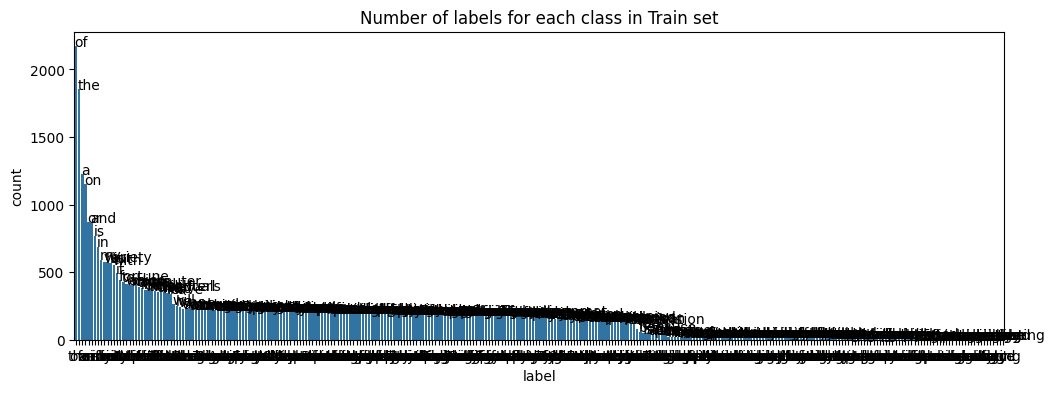

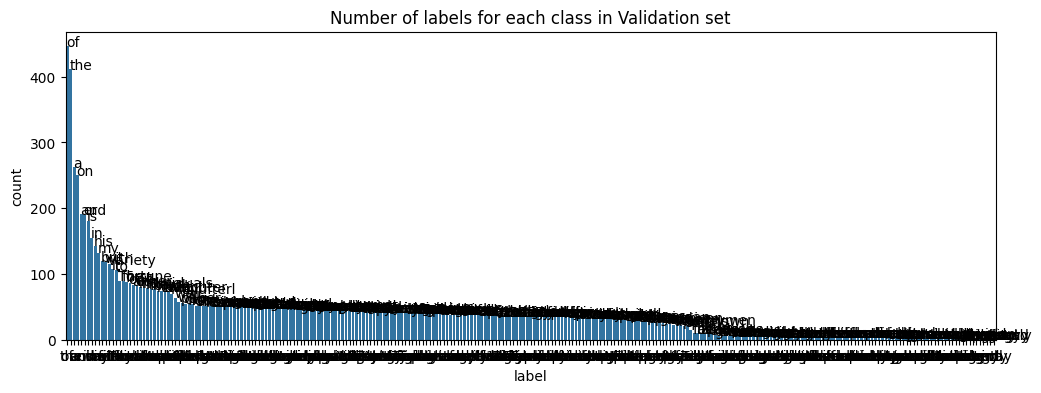

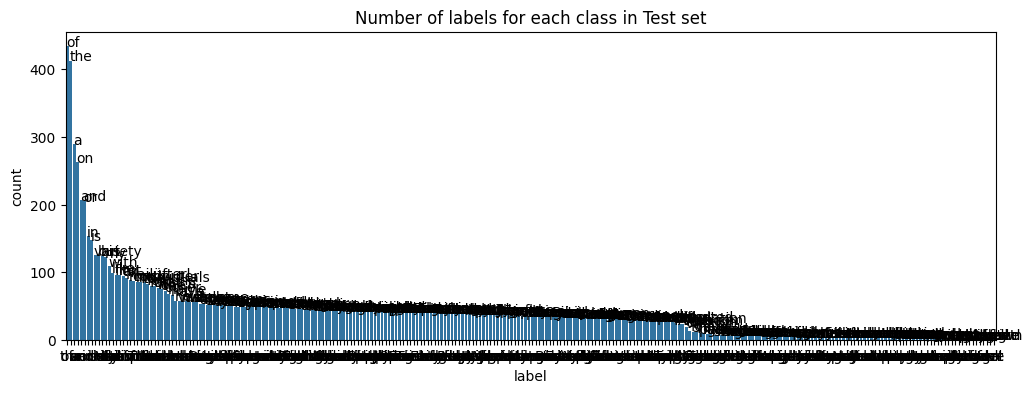

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def get_classes_distribution(loader, split_name="Train", label_dict=None, classes_list=None):
    # Collect all labels from the loader
    labels_list = []
    for _, labels in loader:
        labels_list.extend(labels)
    
    # Create a DataFrame with the labels
    data = pd.DataFrame({"label": labels_list})
    label_counts = data["label"].value_counts()
    total_samples = len(data)
    
    print(f"Class Distribution for {split_name} set:")
    for label, count in label_counts.items():
        percent = (count / total_samples) * 100
        # If label_dict and classes_list are provided, map the raw label to the desired display label.
        if label_dict is not None and classes_list is not None:
            try:
                idx = classes_list.index(label)
                display_label = label_dict[idx]
            except ValueError:
                display_label = label  # fallback if label not found in the list
        else:
            display_label = label
        print("{:<20s}:   {} or {:.1f}%".format(display_label, count, percent))
    print()

def plot_label_per_class(loader, split_name="Train", label_dict=None, classes_list=None):
    # Collect labels for plotting
    labels_list = []
    for _, labels in loader:
        labels_list.extend(labels)
    
    data = pd.DataFrame({"label": labels_list})
    
    # To order the plot according to counts
    order = data["label"].value_counts().index
    plt.figure(figsize=(12, 4))
    g = sns.countplot(x="label", data=data, order=order)
    g.set_title(f"Number of labels for each class in {split_name} set")
    
    # Annotate each bar with the display label using label_dict if provided.
    for p, raw_label in zip(g.patches, order):
        if label_dict is not None and classes_list is not None:
            try:
                idx = classes_list.index(raw_label)
                display_label = label_dict[idx]
            except ValueError:
                display_label = raw_label
        else:
            display_label = raw_label
        g.annotate(display_label, (p.get_x(), p.get_height()+0.1))
    plt.show()


# Example usage:
# Assuming you have created your loaders as follows:
# classes, train_loader, valid_loader, test_loader, label_dict = createLoaders(batch_size=128)

# Now, print and plot class distributions using the label dictionary:
get_classes_distribution(train_loader, "Train", label_dict=label_dict, classes_list=classes)
get_classes_distribution(valid_loader, "Validation", label_dict=label_dict, classes_list=classes)
get_classes_distribution(test_loader, "Test", label_dict=label_dict, classes_list=classes)

plot_label_per_class(train_loader, "Train", label_dict=label_dict, classes_list=classes)
plot_label_per_class(valid_loader, "Validation", label_dict=label_dict, classes_list=classes)
plot_label_per_class(test_loader, "Test", label_dict=label_dict, classes_list=classes)

# 5. Visual Explorations

NameError: name 'train_loader' is not defined